In [3]:
import sys
import time
import pandas as pd

sys.path.append('../')
import lib.functions as f
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

In [18]:
directory="../cooja4-9nodes/"
df = pd.read_csv(directory + "/traces/traces.csv", sep=',', encoding='utf-8')
data=f.import_Cooja2(df,directory)


In [20]:
data[0][0].pkts.head()

,seq,rtt
0,1,722
1,3,391
2,4,332
3,5,3999
4,6,1409


In [25]:
df = pd.read_csv(directory + "/traces/traces.csv", sep=',', encoding='utf-8')

win_25_stats = f.create_stats(directory, df, pings=100, window=25)
win_50_stats = f.create_stats(directory, df, pings=100, window=50)
win_100_stats = f.create_stats(directory, df, pings=100, window=100)
win_200_stats = f.create_stats(directory, df, pings=200, window=200)

stats=pd.DataFrame()
stats=pd.concat([
    win_25_stats,
    win_50_stats,
    win_100_stats,
    win_200_stats,
], ignore_index=True)
stats.to_csv(directory+"stats_per_node.csv", sep=',', encoding='utf-8')

Processing...
Processing...
Processing...
Processing...


In [26]:

stats = pd.read_csv(directory + "/stats_per_node.csv", sep=',', encoding='utf-8')
stats.head()

,Unnamed: 0,experiment,node_id,label,label_2,loss,count,std,mean,var,hop,min,max,outliers,window
0,0,rnd__2019-05-01_13:41_,aaaa::212:7406:6:606,Normal,Normal,32.0,17,892.128490,983.352941,7.958932e+05,2,321,10130,1,25
1,1,rnd__2019-05-01_13:41_,aaaa::212:7406:6:606,Normal,Normal,52.0,12,673.397627,1016.000000,4.534644e+05,2,321,10130,1,25
2,2,rnd__2019-05-01_13:41_,aaaa::212:7406:6:606,Normal,Normal,72.0,7,935.342692,1484.571429,8.748660e+05,2,321,10130,0,25
3,3,rnd__2019-05-01_13:41_,aaaa::212:7406:6:606,Normal,Normal,72.0,7,3016.792084,3746.142857,9.101034e+06,2,321,10130,1,25
4,4,rnd__2019-05-01_13:41_,aaaa::212:7403:3:303,Normal,Normal,28.0,18,608.658624,494.444444,3.704653e+05,1,119,5930,1,25


In [27]:
directory="../cooja3-9nodes/"
df = pd.read_csv(directory + "stats_per_node.csv", sep=',', encoding='utf-8').drop(columns="Unnamed: 0")
    
win_25_stats = df[df["window"] == 25]
win_50_stats = df[df["window"] == 50]
win_100_stats= df[df["window"] == 100]
win_200_stats = df[df["window"] == 200]
trace_stats = {
        25: win_25_stats.drop(columns=["label_2"]),
        50: win_50_stats.drop(columns=["label_2"]),
        100: win_100_stats.drop(columns=["label_2"]),
        200: win_200_stats.drop(columns=["label_2"]),
    }
features_to_drop = [
        'node_id', 'experiment', 'label', "window",
        "mean",
        #'loss',
        'count',
        'outliers',
        "std",
        #"var",
        "hop",
         #"min",
        "max"
    ]

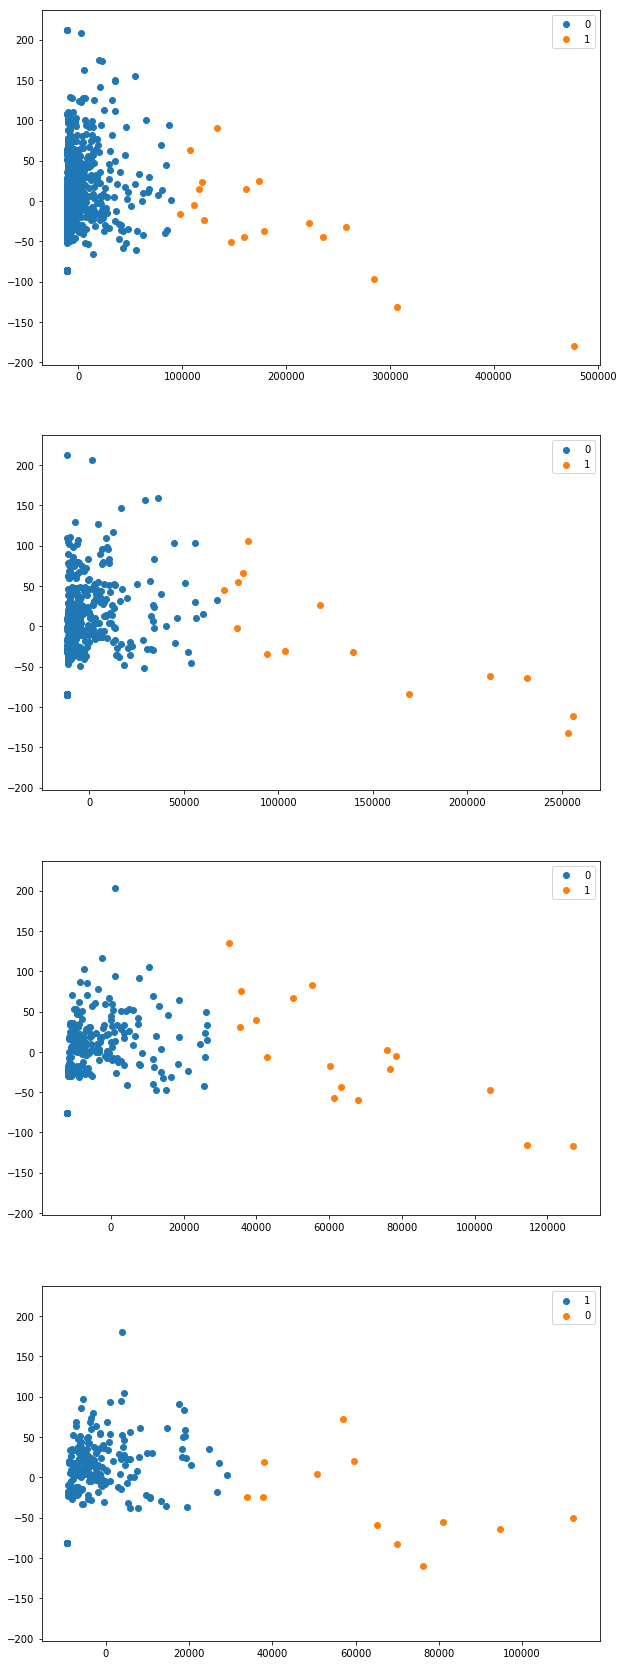

In [28]:
figsize= figsize=(10,30)
fig, axs= plt.subplots(len(trace_stats),1, figsize=figsize,sharey=True, )
count=-1
for trace_size in trace_stats:
    count+=1
   
    trace = trace_stats[trace_size]
    
    target = trace["label"].values
    
    correction = []
    for i in range(len(target)):
        if (i == "Normal"):
            correction.append(0)
        else:
            correction.append(1)
    #dropping features
    features = trace.drop(columns=features_to_drop)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(features)
    labels = kmeans.predict(features)
    
    #labels = f.accuracy_score_corrected(correction, labels)
    
    trace["KmeansLabels"]=labels   
    centroids = kmeans.cluster_centers_
    #print(trace)
    #print(centroids)
    #End of algorithm
    #Try to draw them
    X=features
    pca = PCA(n_components=2)
    pca.fit(X)
    X_ = pca.transform(X)
    dfPCA = pd.DataFrame({'x1': X_[:,0], 'x2': X_[:,1]})
    dfPCA["labels"]=labels
    labels = trace['KmeansLabels'].unique().tolist()
    #plt.figure(figsize=(7,5))
    
   
    
    for lab in labels:
        #print(lab)
        
        #print(dfPCA[dfPCA['labels'] == lab])
        axs[count].scatter(dfPCA.loc[dfPCA['labels'] == lab, 'x1'],  dfPCA.loc[dfPCA['labels'] == lab, 'x2'], label=lab)
        axs[count].legend()
    

In [36]:
trace[trace["KmeansLabels"]==1]

,experiment,node_id,label,loss,count,std,mean,var,hop,min,max,outliers,window,KmeansLabels
1928,grid9_normal_2019-02-13_17:05_,aaaa::212:7409:9:909,Normal,20.5,159,322.706799,499.924528,104139.677812,3,188.0,1710.0,8,200,1
1929,grid9_normal_2019-02-13_17:05_,aaaa::212:7408:8:808,Normal,28.0,144,348.895899,598.534722,121728.348436,4,242.0,2006.0,9,200,1
1930,grid9_normal_2019-02-13_17:05_,aaaa::212:7407:7:707,Normal,25.0,150,262.772379,488.213333,69049.323311,3,214.0,1623.0,7,200,1
1932,grid9_normal_2019-02-13_17:05_,aaaa::212:7404:4:404,Normal,30.0,140,292.643361,340.292857,85640.136639,2,106.0,1563.0,9,200,1
1933,grid9_normal_2019-02-13_17:05_,aaaa::212:740a:a:a0a,Normal,10.0,180,257.730361,497.872222,66424.938889,4,260.0,1945.0,9,200,1
2059,grid9_1bh-9_2019-02-13_19:35_,aaaa::212:740a:a:a0a,Attacked,97.5,5,300.761866,536.800000,90457.700000,4,207.0,897.0,0,200,1
2070,grid9_1bh-5_2019-02-13_21:44_,aaaa::212:7408:8:808,Attacked,21.5,157,217.618247,303.127389,47357.701617,4,168.0,1868.0,6,200,1
2074,grid9_1bh-5_2019-02-13_21:44_,aaaa::212:7407:7:707,Attacked,14.0,172,208.273625,238.354651,43377.902727,3,109.0,2042.0,5,200,1
2075,grid9_1bh-5_2019-02-13_21:44_,aaaa::212:740a:a:a0a,Attacked,18.0,164,245.423079,329.786585,60232.487917,4,176.0,1916.0,5,200,1
2077,grid9_1bh-5_2019-02-13_21:44_,aaaa::212:7405:5:505,Attacked,12.0,176,281.637608,307.772727,79319.742338,3,115.0,2297.0,8,200,1
